<a href="https://colab.research.google.com/github/jujuGthb/Apple_Stock_Price_Prediction_II/blob/main/appl_pred_autoformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Save File to Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# prompt: define working directory for drive

import os
project_dir = os.path.join('/content/drive/My Drive/Colab Notebooks')
model_path = os.path.join(project_dir, 'aapl_stock_prediction_autoforer.keras')


In [ ]:
!pip install --upgrade yfinance
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
import yfinance as yf
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Data collection using yfinance

In [3]:
def download_data_with_retry(ticker, start, end, interval, max_retries=5, delay=5):
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=False)


            print("Download successful!")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(delay)
    print("All retry attempts failed.")
    return None

# Defining parameters
ticker = 'AAPL'
start_date = '2004-01-01'
end_date = '2024-01-01'
interval = '1d'

# Downloading data
data = download_data_with_retry(ticker, start_date, end_date, interval)


if data is not None:
    print(f"Number of records downloaded: {len(data)}")
else:
    print("Data download failed.")

[*********************100%***********************]  1 of 1 completed

Download successful!
Number of records downloaded: 5033


In [ ]:
data.head(5)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2004-01-02,0.320548,0.380000,0.388393,0.378214,0.384821,144642400
2004-01-05,0.333954,0.395893,0.399821,0.382500,0.382500,395018400
2004-01-06,0.332749,0.394464,0.400357,0.387679,0.397321,509348000
2004-01-07,0.340281,0.403393,0.407679,0.391607,0.394643,586874400
2004-01-08,0.351880,0.417143,0.423750,0.404464,0.407857,460303200


In [4]:
# Checking  MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [5]:
data = data.round(2)
data.head(5)

,adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200


## Adding Columns

#### Feature Engineering

In [7]:
# Time-Based Features
data['DayofWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# Lagged Features (previous day's values)
data['Close_Lag1'] = data['Close'].shift(1)
data['Volume_Lag1'] = data['Volume'].shift(1)


data['Price Change %'] = data['Close'].pct_change() * 100
data['Volatility_20'] = data['Close'].rolling(window=20).std()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Interaction Features
data['Close_Volatility'] = data['Close'] * data['Volatility_20']



if isinstance(data.columns, pd.MultiIndex):

    data.columns = data.columns.droplevel(0)

    data.columns = ['adj Close', 'Close', 'High', 'Low', 'Open', 'Volume','Price Change %', 'Volatility_20', 'SMA_50', 'EMA_50']



data = data.round(2)


In [8]:
data.head(5)

,adj Close,Close,High,Low,Open,Volume,DayofWeek,Month,Quarter,Close_Lag1,Volume_Lag1,Price Change %,Volatility_20,SMA_50,EMA_50,Close_Volatility
Date,,,,,,,,,,,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400,4,1,1,NaN,NaN,NaN,NaN,NaN,0.38,NaN
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400,0,1,1,0.38,144642400.0,5.26,NaN,NaN,0.38,NaN
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000,1,1,1,0.40,395018400.0,-2.50,NaN,NaN,0.38,NaN
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400,2,1,1,0.39,509348000.0,2.56,NaN,NaN,0.38,NaN
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200,3,1,1,0.40,586874400.0,5.00,NaN,NaN,0.38,NaN


In [9]:
data.to_csv('AAPL_stock_data.csv')

In [10]:
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])
    data['Days'] = (data['Date'] - data['Date'].min()).dt.days
    data = data.drop(columns=['Date'])

## Data Processing

In [ ]:
data = pd.read_csv('AAPL_stock_data.csv', header=0, parse_dates=['Date'], index_col='Date')

data = data.bfill()



print(f"Data Info:\n {data.info}")
print(f"Sum of null data:\n {data.isnull().sum()}")






In [12]:
data.tail(5)

,adj Close,Close,High,Low,Open,Volume,DayofWeek,Month,Quarter,Close_Lag1,Volume_Lag1,Price Change %,Volatility_20,SMA_50,EMA_50,Close_Volatility
Date,,,,,,,,,,,,,,,,
2023-12-22,192.66,193.60,195.41,192.97,195.18,37122800,4,12,4,194.68,46482500.0,-0.55,2.91,185.40,188.23,563.57
2023-12-26,192.11,193.05,193.89,192.83,193.61,28919300,1,12,4,193.60,37122800.0,-0.28,2.77,185.68,188.42,534.80
2023-12-27,192.21,193.15,193.50,191.09,192.49,48087700,2,12,4,193.05,28919300.0,0.05,2.66,185.97,188.60,513.18
2023-12-28,192.64,193.58,194.66,193.17,194.14,34049900,3,12,4,193.15,48087700.0,0.22,2.43,186.30,188.80,470.50
2023-12-29,191.59,192.53,194.40,191.73,193.90,42628800,4,12,4,193.58,34049900.0,-0.54,2.26,186.63,188.94,434.43


## Visualizing Data

In [ ]:
data.head(5)

,adj Close,Close,High,Low,Open,Volume,RSI,MACD,MACD_signal,MACD_hist,...,Month,Quarter,Close_Lag1,Volume_Lag1,Price Change %,Volatility_20,SMA_50,EMA_50,Close_Volatility,Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.32,0.38,0.39,0.38,0.38,144642400,58.33,-0.0,0.0,-0.0,...,1,1,0.38,144642400.0,5.26,0.01,0.42,0.38,0.0,0.012183
2004-01-05,0.33,0.40,0.40,0.38,0.38,395018400,58.33,-0.0,0.0,-0.0,...,1,1,0.38,144642400.0,5.26,0.01,0.42,0.38,0.0,0.012183
2004-01-06,0.33,0.39,0.40,0.39,0.40,509348000,58.33,-0.0,0.0,-0.0,...,1,1,0.40,395018400.0,-2.50,0.01,0.42,0.38,0.0,0.012183
2004-01-07,0.34,0.40,0.41,0.39,0.39,586874400,58.33,-0.0,0.0,-0.0,...,1,1,0.39,509348000.0,2.56,0.01,0.42,0.38,0.0,0.012183
2004-01-08,0.35,0.42,0.42,0.40,0.41,460303200,58.33,-0.0,0.0,-0.0,...,1,1,0.40,586874400.0,5.00,0.01,0.42,0.38,0.0,0.012183


## Model Building

#### Normalize dataset

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)


data = pd.DataFrame(data_normalized, columns=data.columns)

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


def prepare_data(data, input_length, target_column):
    X, y = [], []
    for i in range(len(data) - input_length):
        X.append(data.iloc[i:i + input_length].values)
        y.append(data.iloc[i + input_length][target_column])
    return np.array(X), np.array(y)

input_length = 60
target_column = 'Close'
X, y = prepare_data(data, input_length, data.columns.get_loc(target_column))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


<ipython-input-18-68f7a6d6bd4d>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data.iloc[i + input_length][target_column])


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Define your Autoformer model here
class Autoformer(nn.Module):
    def __init__(self, input_dim, seq_length, output_dim):
        super(Autoformer, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Example of handling time series data with a linear layer after reshaping
        self.fc = nn.Linear(seq_length * input_dim, output_dim)

    def forward(self, x):
        # Reshape the input to flatten the time steps and features into a single vector
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        return self.fc(x)

# Assuming data is already prepared (X, y) as in your example
def prepare_data(data, input_length, target_column):
    X, y = [], []
    for i in range(len(data) - input_length):
        X.append(data.iloc[i:i + input_length].values)
        y.append(data.iloc[i + input_length][target_column])
    return np.array(X), np.array(y)

input_length = 60
target_column = 'Close'
X, y = prepare_data(data, input_length, target_column)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Model initialization
input_dim = X_train.shape[2]
output_dim = 1

model = Autoformer(input_dim, input_length, output_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with evaluation metrics
epochs = 100
val_losses = []
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred_train = model(X_train)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Compute loss and metrics
    loss = criterion(y_pred_train, y_train.view(-1, 1))
    mae = torch.mean(torch.abs(y_pred_train - y_train.view(-1, 1)))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        val_loss = criterion(y_pred_test, y_test.view(-1, 1))
        val_mae = torch.mean(torch.abs(y_pred_test - y_test.view(-1, 1)))

    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {loss.item():.4f}, Train MAE: {mae.item():.4f} - "
          f"Val Loss: {val_loss.item():.4f}, Val MAE: {val_mae.item():.4f}")


Epoch [1/100] - Train Loss: 0.2850, Train MAE: 0.3766 - Val Loss: 0.0795, Val MAE: 0.2046
Epoch [2/100] - Train Loss: 0.0781, Train MAE: 0.2009 - Val Loss: 0.0485, Val MAE: 0.1792
Epoch [3/100] - Train Loss: 0.0456, Train MAE: 0.1717 - Val Loss: 0.0903, Val MAE: 0.2624
Epoch [4/100] - Train Loss: 0.0885, Train MAE: 0.2585 - Val Loss: 0.1081, Val MAE: 0.2853
Epoch [5/100] - Train Loss: 0.1074, Train MAE: 0.2826 - Val Loss: 0.0851, Val MAE: 0.2411
Epoch [6/100] - Train Loss: 0.0849, Train MAE: 0.2393 - Val Loss: 0.0470, Val MAE: 0.1656
Epoch [7/100] - Train Loss: 0.0467, Train MAE: 0.1651 - Val Loss: 0.0205, Val MAE: 0.1070
Epoch [8/100] - Train Loss: 0.0202, Train MAE: 0.1076 - Val Loss: 0.0180, Val MAE: 0.1136
Epoch [9/100] - Train Loss: 0.0180, Train MAE: 0.1137 - Val Loss: 0.0337, Val MAE: 0.1578
Epoch [10/100] - Train Loss: 0.0342, Train MAE: 0.1601 - Val Loss: 0.0506, Val MAE: 0.1962
Epoch [11/100] - Train Loss: 0.0514, Train MAE: 0.1997 - Val Loss: 0.0552, Val MAE: 0.2065
Epoch [1

### Evaluate the Model

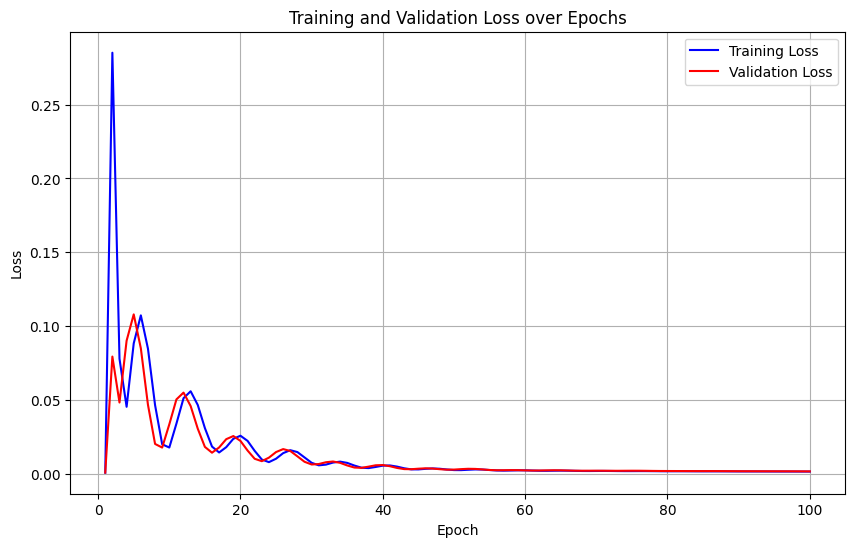

In [22]:
import matplotlib.pyplot as plt

epochs = len(train_losses)

# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Convert X_test to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Evaluate the model
with torch.no_grad():
    model.eval()
    y_pred = []
    for X_batch in X_test_tensor:
        pred = model(X_batch.unsqueeze(0))
        y_pred.append(pred.item())


<ipython-input-24-bcc3fde922e2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


#### Metrics Values

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test = y_test.cpu().numpy()

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Absolute Percentage Error (MAPE)
# Avoid dividing by zero
mape = np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-10, None))) * 100

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MSE: 0.0018885269228898678
MAE: 0.03327818253257747
MAPE: 204.50695638448627%
RMSE: 0.0434571849397757
R-squared: 0.97409732330604


In [35]:
torch.save(model.state_dict(), model_path)

#### Plot True and Predicted Price

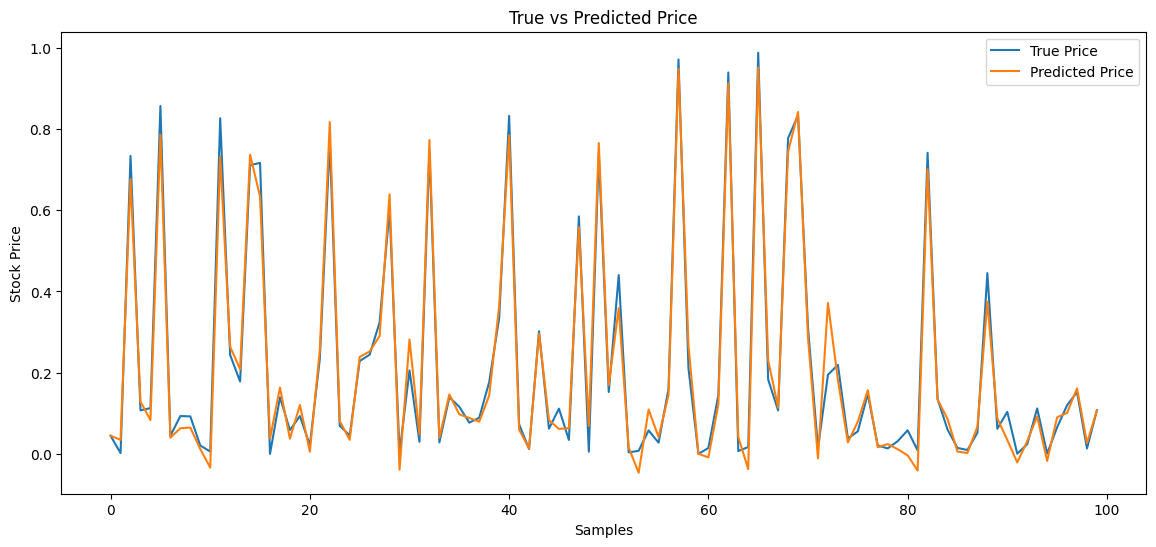

In [37]:
import matplotlib.pyplot as plt

# Squeeze y_pred if it is a NumPy array
y_pred = np.squeeze(y_pred)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test[:100], label="True Price")
plt.plot(y_pred[:100], label="Predicted Price")

plt.title("True vs Predicted Price")
plt.xlabel("Samples")
plt.ylabel("Stock Price")
plt.legend()
plt.show()






#### Calculate Indicators

#### Compare True Prices with Predicted Prices

In [ ]:
for true_val, pred_val in zip(y_test, y_pred):
    print(f"True Prices: {true_val:.4f}, Predicted Prices: {pred_val:.4f}")

True Prices: 0.0451, Predicted Prices: 0.0236
True Prices: 0.0024, Predicted Prices: 0.0692
True Prices: 0.7334, Predicted Prices: 0.7218
True Prices: 0.1075, Predicted Prices: 0.1472
True Prices: 0.1130, Predicted Prices: 0.0802
True Prices: 0.8562, Predicted Prices: 0.7959
True Prices: 0.0448, Predicted Prices: 0.0574
True Prices: 0.0934, Predicted Prices: 0.0622
True Prices: 0.0927, Predicted Prices: 0.0692
True Prices: 0.0210, Predicted Prices: 0.0413
True Prices: 0.0061, Predicted Prices: -0.0080
True Prices: 0.8263, Predicted Prices: 0.7924
True Prices: 0.2436, Predicted Prices: 0.2708
True Prices: 0.1785, Predicted Prices: 0.1808
True Prices: 0.7107, Predicted Prices: 0.7751
True Prices: 0.7163, Predicted Prices: 0.6811
True Prices: 0.0005, Predicted Prices: -0.0190
True Prices: 0.1395, Predicted Prices: 0.1828
True Prices: 0.0590, Predicted Prices: -0.0011
True Prices: 0.0934, Predicted Prices: 0.0707
True Prices: 0.0219, Predicted Prices: 0.0218
True Prices: 0.2345, Predicted 